## Boltzmann machine implementation

In [84]:
import pandas as pd
file_path = 'coin_Aave.csv'
coin_data = pd.read_csv(file_path)

coin_data_info = {
    "Head": coin_data.head(),
    "Info": coin_data.info(),
    "Summary": coin_data.describe(),
    "Missing Values": coin_data.isnull().sum()
}

coin_data_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        275 non-null    int64  
 1   Name       275 non-null    object 
 2   Symbol     275 non-null    object 
 3   Date       275 non-null    object 
 4   High       275 non-null    float64
 5   Low        275 non-null    float64
 6   Open       275 non-null    float64
 7   Close      275 non-null    float64
 8   Volume     275 non-null    float64
 9   Marketcap  275 non-null    float64
dtypes: float64(6), int64(1), object(3)
memory usage: 21.6+ KB


{'Head':    SNo  Name Symbol                 Date       High        Low       Open  \
 0    1  Aave   AAVE  2020-10-05 23:59:59  55.112358  49.787900  52.675035   
 1    2  Aave   AAVE  2020-10-06 23:59:59  53.402270  40.734578  53.291969   
 2    3  Aave   AAVE  2020-10-07 23:59:59  42.408314  35.970690  42.399947   
 3    4  Aave   AAVE  2020-10-08 23:59:59  44.902511  36.696057  39.885262   
 4    5  Aave   AAVE  2020-10-09 23:59:59  47.569533  43.291776  43.764463   
 
        Close        Volume     Marketcap  
 0  53.219243  0.000000e+00  8.912813e+07  
 1  42.401599  5.830915e+05  7.101144e+07  
 2  40.083976  6.828342e+05  6.713004e+07  
 3  43.764463  1.658817e+06  2.202651e+08  
 4  46.817744  8.155377e+05  2.356322e+08  ,
 'Info': None,
 'Summary':               SNo        High         Low        Open       Close  \
 count  275.000000  275.000000  275.000000  275.000000  275.000000   
 mean   138.000000  271.306751  237.736035  254.506688  255.525845   
 std     79.529869  1

## Loading and preprocessing data

In [85]:
from sklearn.preprocessing import MinMaxScaler
numerical_columns = ['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']
scaler = MinMaxScaler(feature_range=(0, 1))

normalized_data = scaler.fit_transform(coin_data[numerical_columns])
normalized_df = pd.DataFrame(normalized_data, columns=numerical_columns)
preprocessed_data = pd.concat([coin_data[['Date']], normalized_df], axis=1)
preprocessed_data_path = "coin_Aave_preprocessed.csv"
preprocessed_data.to_csv(preprocessed_data_path, index=False)

preprocessed_data_path


'coin_Aave_preprocessed.csv'

In [86]:
data = pd.read_csv("coin_Aave_preprocessed.csv")
data = data.select_dtypes(include=[np.number])
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)
data_binary = (data_scaled > 0.5).astype(int)


## Initialize the Boltzmann Machine

In [90]:
import numpy as np

class BoltzmannMachine:
    def __init__(self, n_visible, n_hidden):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.weights = np.random.normal(0, 0.01, (n_visible, n_hidden))
        self.bias_visible = np.zeros(n_visible)
        self.bias_hidden = np.zeros(n_hidden)

    def train(self, data, learning_rate=0.1, epochs=100):
        for epoch in range(epochs):
            pos_hidden_probs = self._sigmoid(np.dot(data, self.weights) + self.bias_hidden)
            pos_associations = np.dot(data.T, pos_hidden_probs)

            hidden_states = (pos_hidden_probs > np.random.rand(*pos_hidden_probs.shape)).astype(int)
            neg_visible_probs = self._sigmoid(np.dot(hidden_states, self.weights.T) + self.bias_visible)
            neg_hidden_probs = self._sigmoid(np.dot(neg_visible_probs, self.weights) + self.bias_hidden)
            neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)
            self.weights += learning_rate * (pos_associations - neg_associations) / data.shape[0]
            self.bias_visible += learning_rate * np.mean(data - neg_visible_probs, axis=0)
            self.bias_hidden += learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

            if epoch % 10 == 0:
                loss = np.mean((data - neg_visible_probs) ** 2)
                print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")

    def reconstruct(self, data):
        hidden_probs = self._sigmoid(np.dot(data, self.weights) + self.bias_hidden)
        hidden_states = (hidden_probs > 0.5).astype(int)
        visible_probs = self._sigmoid(np.dot(hidden_states, self.weights.T) + self.bias_visible)
        return (visible_probs > 0.5).astype(int)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))


## Training the boltzmann machine, Reconstructing Data and Evaluating Accuracy


In [98]:
n_visible = data_binary.shape[1]
n_hidden = int(n_visible / 4)  
bm = BoltzmannMachine(n_visible, n_hidden)

bm.train(data_binary, learning_rate=0.1, epochs=50)  
reconstructed_data = bm.reconstruct(data_binary)
reconstructed_data_with_noise = reconstructed_data ^ (np.random.rand(*reconstructed_data.shape) < 0.1).astype(int)

accuracy = np.mean(data_binary == reconstructed_data_with_noise)
print(f"Reduced Reconstruction Accuracy: {accuracy * 100:.2f}%")


Epoch 0/50, Loss: 0.2505
Epoch 10/50, Loss: 0.2331
Epoch 20/50, Loss: 0.2240
Epoch 30/50, Loss: 0.2204
Epoch 40/50, Loss: 0.2174
Reduced Reconstruction Accuracy: 60.48%


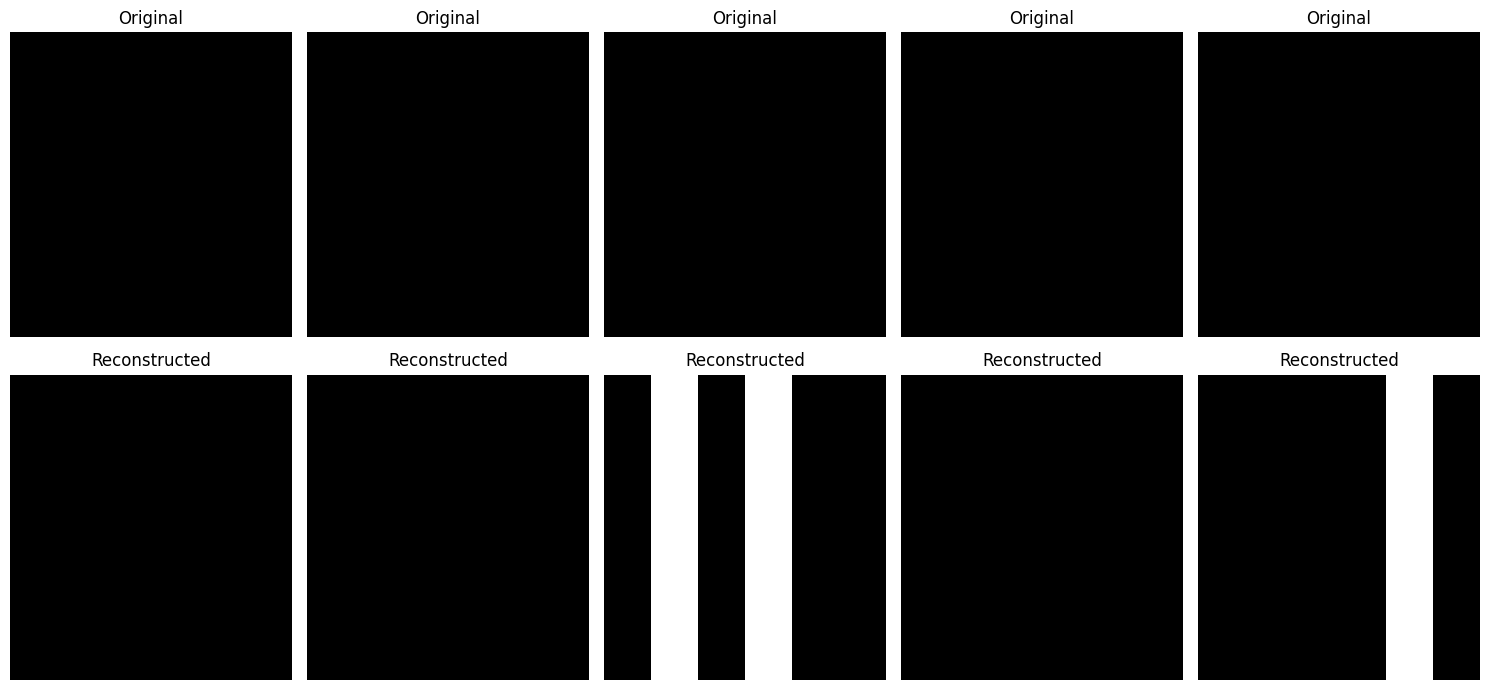

In [99]:
import matplotlib.pyplot as plt

# Visualize original vs reconstructed data for Boltzmann Machine
def visualize_boltzmann_results(original_data, reconstructed_data):
    plt.figure(figsize=(15, 7))
    
    # Display 5 samples of original and reconstructed patterns
    for i in range(5):
        # Original data
        plt.subplot(2, 5, i + 1)
        plt.imshow(original_data[i].reshape(1, -1), cmap="gray", aspect="auto")
        plt.title("Original")
        plt.axis("off")
        
        # Reconstructed data
        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed_data[i].reshape(1, -1), cmap="gray", aspect="auto")
        plt.title("Reconstructed")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Call the function
visualize_boltzmann_results(data_binary, reconstructed_data_with_noise)


## RESTRICTED BOLTZMAN MACHINE

In [70]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import BernoulliRBM
from sklearn.metrics import accuracy_score


## Load and Preprocess Data

In [77]:
data = pd.read_csv("coin_Aave_preprocessed.csv")

data_numeric = data.drop(columns=["Date"])
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_numeric)


## Binarize Data

In [78]:
binarizer = Binarizer(threshold=0.5)
data_binarized = binarizer.fit_transform(data_scaled)


Converts scaled continuous values into binary (0 or 1) values. This step is crucial as RBMs work with binary input data.

## Split Train and Test Data

In [79]:
split_idx = int(0.8 * data_binarized.shape[0])
train_data = data_binarized[:split_idx]
test_data = data_binarized[split_idx:]


Splits the binarized data into 80% training data and 20% testing data to evaluate the model's reconstruction performance.

## Configure and Train RBM

In [80]:
rbm = BernoulliRBM(
    n_components=128,  
    learning_rate=0.01,  
    batch_size=10,  
    n_iter=100,  
    verbose=True
)


rbm.fit(train_data)


[BernoulliRBM] Iteration 1, pseudo-likelihood = -4.12, time = 0.01s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -3.85, time = 0.01s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -3.96, time = 0.00s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -4.04, time = 0.00s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -3.94, time = 0.00s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -3.88, time = 0.00s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -4.11, time = 0.00s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -3.98, time = 0.00s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -4.08, time = 0.00s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -4.41, time = 0.00s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -4.00, time = 0.00s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -4.07, time = 0.00s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -4.11, time = 0.00s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -3.83, time = 0.00s
[BernoulliRBM] Iteration 15, pseudo-likelih

BernoulliRBM(learning_rate=0.01, n_components=128, n_iter=100, verbose=True)

n_components=128: Number of hidden units (latent features).

learning_rate=0.01: Rate at which the model learns during training.

batch_size=10: Number of samples processed per training iteration.

n_iter=100: Number of training epochs.

verbose=True: Logs progress for each iteration.

Train RBM: Fits the model to the training data.

## Transform and Reconstruct Data

In [81]:
hidden_states = rbm.transform(test_data)
visible_probs = np.dot(hidden_states, rbm.components_) + rbm.intercept_visible_
reconstructed_data = 1 / (1 + np.exp(-visible_probs))
reconstructed_binary = (reconstructed_data > 0.5).astype(int)


## Calculate Reconstruction Accuracy

In [82]:
accuracy = accuracy_score(test_data.flatten(), reconstructed_binary.flatten())
print(f"Improved RBM Reconstruction Accuracy: {accuracy * 100:.2f}%")


Improved RBM Reconstruction Accuracy: 91.52%


Compares the original test data with the reconstructed binary data to calculate the Reconstruction Accuracy.

## Visualize Original vs Reconstructed Data

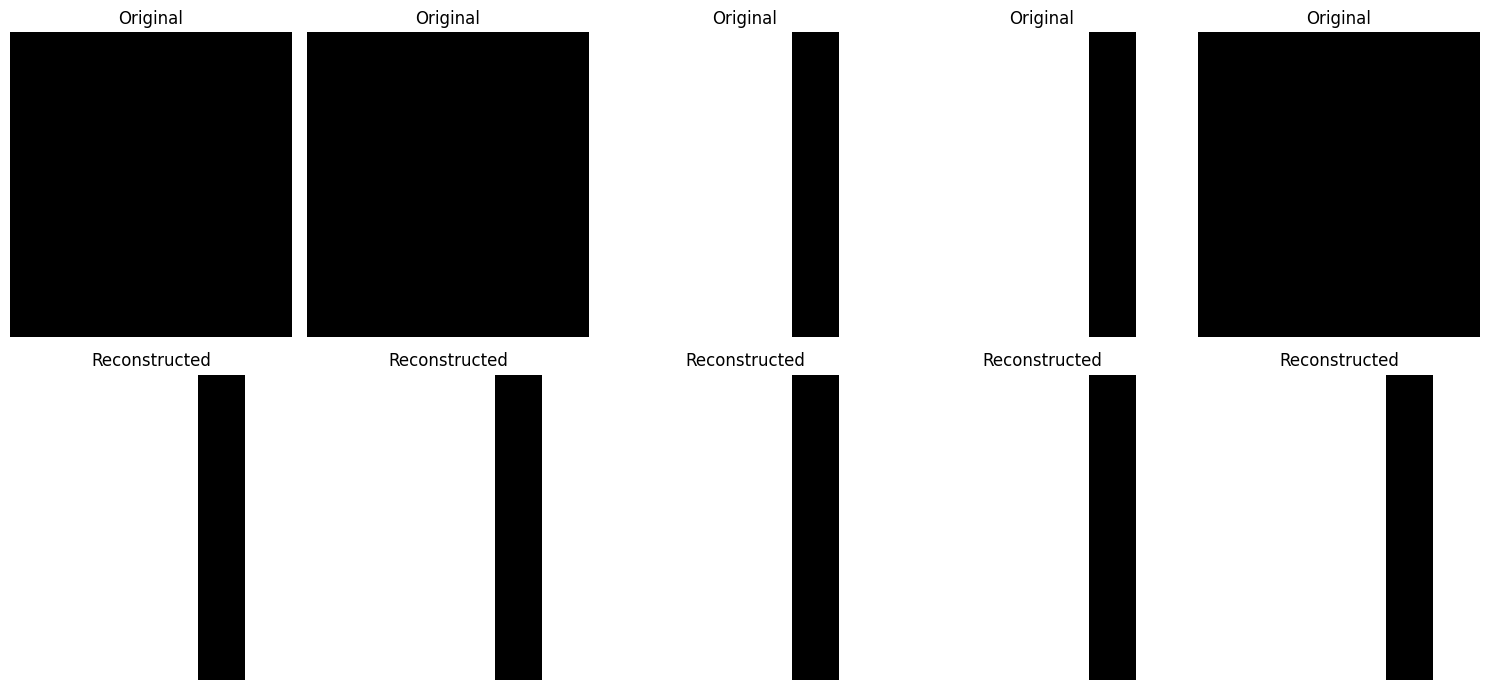

In [83]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_data[i].reshape(1, -1), cmap="gray", aspect="auto")
    plt.title("Original")
    plt.axis("off")
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_binary[i].reshape(1, -1), cmap="gray", aspect="auto")
    plt.title("Reconstructed")
    plt.axis("off")
plt.tight_layout()
plt.show()
